#1. Min-max Gray Level Enhancement


In [ ]:
import cv2
import numpy as np

image = cv2.imread('00001.jpg', cv2.IMREAD_GRAYSCALE)

min_val, max_val = np.min(image), np.max(image)
normalized_image = 255 * (image - min_val) / (max_val - min_val)

cv2.imwrite('normalized_image.jpg', normalized_image)

True

#2. Otsu-based Image Thresholding

In [ ]:
image = cv2.imread('normalized_image.jpg', cv2.IMREAD_GRAYSCALE)

_, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

cv2.imwrite('otsu_thresholded_image.jpg', thresholded_image)

True

#3. Image Cleaning (Pixel Size and ARI)

In [ ]:
from skimage.measure import label, regionprops
from skimage.draw import ellipse_perimeter

image = cv2.imread('otsu_thresholded_image.jpg', cv2.IMREAD_GRAYSCALE)

label_image = label(image)

min_pixels = 50
ari_threshold = 0.8

cleaned_image = np.zeros_like(image)

for region in regionprops(label_image):
    if region.area >= min_pixels:
        if region.minor_axis_length > 0:
            ari = region.major_axis_length / region.minor_axis_length
            # If ARI is above threshold, keep the object
            if ari >= ari_threshold:
                for coord in region.coords:
                    cleaned_image[coord[0], coord[1]] = 255

cv2.imwrite('cleaned_image.jpg', cleaned_image)

True

# Crack Quantification

<ipython-input-1-760019387c48>:46: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Crack Area: 2948.50 px²
Crack Perimeter: 707.03 px
Crack Length: 225.89 px
Crack Width: 53.33 px


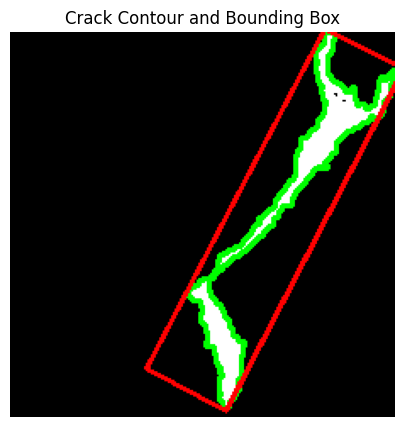

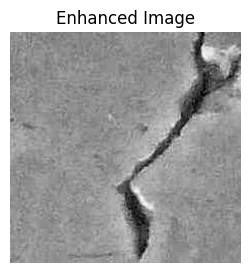

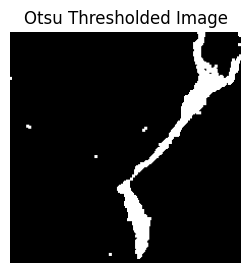

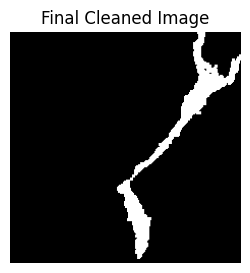

Processing complete. Check saved images for each step.


In [ ]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

def enhance_contrast(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    cv2.imwrite(output_path, enhanced_image)
    return enhanced_image

def otsu_thresholding(image, output_path, adjust_value=0):
    otsu_thresh_val, otsu_thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adjusted_threshold = otsu_thresh_val + adjust_value
    _, manually_thresholded_image = cv2.threshold(image, adjusted_threshold, 255, cv2.THRESH_BINARY)
    inverted_image = cv2.bitwise_not(manually_thresholded_image)
    kernel = np.ones((3, 3), np.uint8)
    cleaned_thresholded_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    cv2.imwrite(output_path, cleaned_thresholded_image)
    return cleaned_thresholded_image

def image_cleaning(thresholded_image, output_path, min_pixels=50, ari_threshold=0.5):
    label_image = label(thresholded_image)
    cleaned_image = np.zeros_like(thresholded_image)
    for region in regionprops(label_image):
        if region.area >= min_pixels:
            if region.minor_axis_length > 0:
                ari = region.major_axis_length / region.minor_axis_length
                if ari >= ari_threshold:
                    for coord in region.coords:
                        cleaned_image[coord[0], coord[1]] = 255
    cv2.imwrite(output_path, cleaned_image)
    return cleaned_image

def quantify_crack_properties(cleaned_image):
    contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        crack_length = np.linalg.norm(box[0] - box[1])

        crack_width = min(rect[1])

        print(f"Crack Area: {area:.2f} px²")
        print(f"Crack Perimeter: {perimeter:.2f} px")
        print(f"Crack Length: {crack_length:.2f} px")
        print(f"Crack Width: {crack_width:.2f} px")

        result_image = cv2.cvtColor(cleaned_image, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(result_image, [contour], -1, (0, 255, 0), 2)
        cv2.drawContours(result_image, [box], -1, (255, 0, 0), 2)
        plt.figure(figsize=(5, 5))
        plt.imshow(result_image)
        plt.title("Crack Contour and Bounding Box")
        plt.axis('off')
        plt.show()

def show_image(image, title="Image"):
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def crack_detection_pipeline(image_path):
    enhanced_image_path = 'enhanced_image.jpg'
    otsu_image_path = 'otsu_thresholded_image.jpg'
    cleaned_image_path = 'cleaned_image.jpg'

    enhanced_image = enhance_contrast(image_path, enhanced_image_path)
    otsu_thresholded_image = otsu_thresholding(enhanced_image, otsu_image_path, adjust_value=10)
    cleaned_image = image_cleaning(otsu_thresholded_image, cleaned_image_path, min_pixels=50, ari_threshold=0.5)
    quantify_crack_properties(cleaned_image)

    show_image(enhanced_image, title="Enhanced Image")
    show_image(otsu_thresholded_image, title="Otsu Thresholded Image")
    show_image(cleaned_image, title="Final Cleaned Image")

    print("Processing complete. Check saved images for each step.")

crack_detection_pipeline('00024.jpg')